In [1]:
# %%
%matplotlib widget

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np 
import ipywidgets as widgets
import pandas as pd
from scipy.stats import nbinom
from GCRsim_v02f import CosmicRaySimulation

from pathlib import Path
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

def electron_conversion(dE, f_eff=2.71, w=2.509):
    if dE <= 0:
        return 0
    dE = dE*1e6 # changing MeV to eV
    mu_nb = dE / w
    p = 1.0 / f_eff
    if not (0 < p < 1):
        return 0
    r = mu_nb * (p / (1.0 - p))
    if r <= 0:
        return 0
    return nbinom(r, p).rvs()

In [ ]:
# ---- User Settings ----
csvfile = '202506242308_energy_loss_log.csv'
pixel_size = 10.0         # µm
grid_pixels = 2
window_size = grid_pixels * pixel_size  # 20 µm
bin_size = 0.01           # µm
nbins = int(window_size / bin_size)     # 2000
chunksize = 100_000


# Step 1: Find the first primary PID in the file
primary_pid = None
for chunk in pd.read_csv(csvfile, sep=',', chunksize=1):
    primary_pid = chunk['PID'].iloc[0]
    break

# Step 2: Collect all events for this primary (and its delta rays) as discrete electrons
x_electrons, y_electrons = [], []
x_events, y_events = [], []

for chunk in pd.read_csv(csvfile, sep=',', chunksize=chunksize):
    pids = chunk['PID'].to_numpy()
    xs = chunk['x'].to_numpy()
    ys = chunk['y'].to_numpy()
    dEs = chunk['dE'].to_numpy()
    parent_pids = np.array([CosmicRaySimulation.get_parent_pid(pid) for pid in pids])
    mask = (parent_pids == primary_pid)
    xs_sel = xs[mask]
    ys_sel = ys[mask]
    dEs_sel = dEs[mask]

    for x, y, dE in zip(xs_sel, ys_sel, dEs_sel):
        n_electrons = electron_conversion(dE)
        if n_electrons > 0:
            # Add for centroid calculation
            x_events.append(x)
            y_events.append(y)
            # For each electron, add individual (x, y)
            x_electrons.extend([x] * n_electrons)
            y_electrons.extend([y] * n_electrons)

if len(x_electrons) == 0:
    print("No electrons found for first primary PID!")
else:
    # Step 3: Center grid on mean event position (from events, not electrons)
    x0 = np.mean(x_events)
    y0 = np.mean(y_events)
    x_min = x0 - (window_size / 2)
    x_max = x0 + (window_size / 2)
    y_min = y0 - (window_size / 2)
    y_max = y0 + (window_size / 2)

    # Step 4: Mask electrons within the window
    x_electrons = np.array(x_electrons)
    y_electrons = np.array(y_electrons)
    mask_e = (x_electrons >= x_min) & (x_electrons < x_max) & (y_electrons >= y_min) & (y_electrons < y_max)
    xs_window = x_electrons[mask_e]
    ys_window = y_electrons[mask_e]

    # Step 5: Histogram (each electron = 1 count)
    H, xedges, yedges = np.histogram2d(
        xs_window, ys_window,
        bins=[nbins, nbins],
        range=[[x_min, x_max], [y_min, y_max]]
    )

    # Step 6: Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)

    # Linear plot
    im0 = axs[0].imshow(
        H,
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[0].set_title('Linear scale')
    axs[0].set_xlabel('x (µm)')
    axs[0].set_ylabel('y (µm)')
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Electrons')

    # Log1p plot
    im1 = axs[1].imshow(
        np.log1p(H),
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[1].set_title('Log scale (log1p)')
    axs[1].set_xlabel('x (µm)')
    axs[1].set_ylabel('y (µm)')
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label('log(1 + electrons)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:

def block_average(arr, factor):
    # arr shape: (ny, nx)
    ny, nx = arr.shape
    ny_trim = ny - ny % factor  # ensure divisible
    nx_trim = nx - nx % factor
    arr = arr[:ny_trim, :nx_trim]
    return arr.reshape(ny_trim // factor, factor, nx_trim // factor, factor).mean(axis=(1, 3))

# If you want to use floor instead of mean:
def block_floor(arr, factor):
    ny, nx = arr.shape
    ny_trim = ny - ny % factor
    nx_trim = nx - nx % factor
    arr = arr[:ny_trim, :nx_trim]
    return arr.reshape(ny_trim // factor, factor, nx_trim // factor, factor).sum(axis=(1, 3)).astype(int)


In [ ]:
# Downsample with block averaging
downsample = 10
H3d = block_average(H, downsample)
nbins_x, nbins_y = H3d.shape

x = np.linspace(x_min, x_max, nbins_x)
y = np.linspace(y_min, y_max, nbins_y)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, H3d, cmap='viridis', edgecolor='none', rstride=1, cstride=1, antialiased=True)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('Mean electrons per downsampled bin')
ax.set_title('3D Block-Averaged Electron Count')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Mean electrons')
plt.tight_layout()
plt.show()

# Downsample with block averaging
downsample = 30
H3d = block_average(H, downsample)
nbins_x, nbins_y = H3d.shape

x = np.linspace(x_min, x_max, nbins_x)
y = np.linspace(y_min, y_max, nbins_y)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, H3d.T, cmap='viridis', edgecolor='none', rstride=1, cstride=1, antialiased=True)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('Mean electrons per downsampled bin')
ax.set_title('3D Block-Averaged Electron Count')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Mean electrons')
plt.tight_layout()
plt.show()



In [ ]:
try:
    here = Path(__file__).parent
except NameError:
    here = Path.cwd()

# --- Load single difference frame for noise estimate ---
diff_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'
with fits.open(diff_path) as hdulist:
    diff_data = hdulist[0].data
    if diff_data.ndim == 3:
        diff_data = diff_data[0]

# --- Load flat field and dark data ---
flat_path = here / 'cflat-20663.fits'
with fits.open(flat_path) as hdulist:
    flat_data = hdulist[0].data.astype(float)

dark_path = here / 'dark-20663.fits'
with fits.open(dark_path) as hdulist:
    dark_data = hdulist[0].data.astype(float)

# --- Normalize flat by median (robust gain map) ---
flat_norm = flat_data / np.nanmedian(flat_data)

# --- Median background from dark ---
background_median = np.nanmedian(dark_data)
# --- Robust noise estimate from difference frame using MAD ---
mad = median_abs_deviation(diff_data, scale='normal', nan_policy='omit', axis=None)
# For diff frames (difference of two frames), divide by sqrt(2) for single-frame equivalent
robust_sigma = mad / np.sqrt(2)
print(f"Background (median of dark): {background_median:.2f}")
print(f"Robust sigma (MAD from diff frame): {robust_sigma:.2f}")

ny, nx = H.shape
N, M = flat_norm.shape
H_padded = np.zeros((N, M), dtype=H.dtype)
start_y = (N - ny) // 2
start_x = (M - nx) // 2
H_padded[start_y:start_y+ny, start_x:start_x+nx] = H

# 1. Expand gain map to match full detector size
gain_array = np.loadtxt('Select_20663X_summary.txt')[:, 5].reshape((32, 32))
supercell_size = 128  # pixels per supercell

# Use np.kron to expand the gain map (repeats each value as a block of 128x128 pixels)
gain_map = np.kron(gain_array, np.ones((supercell_size, supercell_size)))

# Check the shape matches your detector (should be 4096x4096)
assert gain_map.shape == flat_norm.shape, f"Gain map shape {gain_map.shape} does not match detector shape {flat_norm.shape}"

# 2. Convert simulated electrons to DNs (avoid divide by zero)
gain_map_safe = np.where(gain_map > 0, gain_map, np.nan)  # or set to 1 to avoid nan/inf
H_DN = H_padded / gain_map_safe

# 3. Simulate background and noise (background and noise are already in DN if real flats/darks/diffs are in DN)
rng = np.random.default_rng()
sim_with_bg = H_DN + background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)

# 4. Plot
plt.figure(figsize=(12, 8))
plt.title("Simulated cosmic ray (DN) + simulated background")
plt.imshow(sim_with_bg,origin="lower", cmap='gray')
plt.colorbar(label='DN')
plt.tight_layout()
plt.show()

In [ ]:
pixel_size = 10.0  # µm
det_pixels = 4096
det_size_um = det_pixels * pixel_size

# Bin simulated electrons onto the full detector pixel grid
# (all values in [0, det_size_um])
H_object_full = np.histogram2d(
    x_events, y_events,
    bins=[det_pixels, det_pixels],
    range=[[0, det_size_um], [0, det_size_um]]
)[0]  # [0] is the histogram counts, i.e. electrons per pixel

# Now H_object_full.shape == (4096, 4096), aligned with your flats, darks, and gain map
H_object_DN = H_object_full / gain_map_safe

sim_with_bg = H_object_DN + background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)
plt.figure(figsize=(12, 8))
plt.title("Simulated object (properly scaled and binned) + background")
plt.imshow(sim_with_bg, origin='lower', cmap='gray', vmin=np.percentile(sim_with_bg, 1), vmax=np.percentile(sim_with_bg, 99))
plt.colorbar(label='DN')
plt.tight_layout()
plt.show()


In [ ]:
# Compute centroid or bounding box of object
yy, xx = np.nonzero(H_object_DN)
if len(xx) == 0:
    print("No object found in simulation!")
else:
    centroid_x = np.mean(xx)
    centroid_y = np.mean(yy)
    # Option: Compute the object's spatial extent
    radius = max(
        np.max(np.abs(xx - centroid_x)),
        np.max(np.abs(yy - centroid_y)),
        30  # minimum radius, in pixels
    ) + 20  # add a small margin

    # Prepare overlay as before
    object_mask = H_object_DN > 0
    overlay = np.zeros((*H_object_DN.shape, 4))
    overlay[..., 0] = 1.0  # Red
    overlay[..., 3] = object_mask * 0.7

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Simulated GCR on simulated background")

    im = ax.imshow(sim_with_bg, origin='lower',  cmap='gray',
                   vmin=np.percentile(sim_with_bg, 1),
                   vmax=np.percentile(sim_with_bg, 99),
                   interpolation='nearest')
    ax.imshow(overlay, origin='lower', interpolation='nearest')

    # Draw green circle around object
    circle = Circle((centroid_x, centroid_y), radius, 
                    color='lime', fill=False, linewidth=2.5, alpha=0.9)
    ax.add_patch(circle)

    plt.colorbar(im, ax=ax, label='DN')
    plt.tight_layout()
    plt.show()


In [ ]:
# Reconstruct the "background only" image (without the object)
background_only = background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)

# Compute the difference image (sim_with_bg - background)
delta_DN = sim_with_bg - background_only

# Create a mask of where the simulated object landed
object_mask = H_object_DN > 0

# Extract DN changes in those pixels
changed_DNs = delta_DN[object_mask]

print(f"Number of pixels affected: {object_mask.sum()}")
print("DN change in those pixels:", changed_DNs)
print(f"Mean DN change: {np.mean(changed_DNs):.2f} | Max: {np.max(changed_DNs):.2f} | Min: {np.min(changed_DNs):.2f}")

# show pixel coordinates and DN change
yy, xx = np.nonzero(object_mask)
for x, y, dn in zip(xx, yy, changed_DNs):
    print(f"Pixel ({x},{y}): ΔDN = {dn:.2f}")


In [ ]:

# ---- User Settings ----
csvfile = '202506242308_energy_loss_log.csv'
pixel_size = 10.0
det_pixels = 4096
det_size_um = det_pixels * pixel_size
chunksize = 200_000

# --- 1. Find all unique primary PIDs (by zeroing out delta ray bits) ---
primary_pids = set()
for chunk in pd.read_csv(csvfile, sep=',', usecols=['PID'], chunksize=chunksize):
    for pid in chunk['PID']:
        primary_pids.add(CosmicRaySimulation.get_parent_pid(pid))
primary_pids = sorted(primary_pids)
print(f"Found {len(primary_pids)} unique primaries.")

# --- 2. Prepare empty histogram (full detector) ---
H_object_full = np.zeros((det_pixels, det_pixels), dtype=np.uint32)

# --- 3. Process each primary separately ---
for primary_pid in tqdm(primary_pids, desc="Processing primaries"):
    x_events, y_events = [], []

    for chunk in pd.read_csv(csvfile, sep=',', chunksize=chunksize):
        pids = chunk['PID'].to_numpy()
        xs = chunk['x'].to_numpy()
        ys = chunk['y'].to_numpy()
        dEs = chunk['dE'].to_numpy()
        parent_pids = np.array([CosmicRaySimulation.get_parent_pid(pid) for pid in pids])
        mask = (parent_pids == primary_pid)
        xs_sel = xs[mask]
        ys_sel = ys[mask]
        dEs_sel = dEs[mask]

        # Simulate electrons for each event (assume electron_conversion is defined and does dE_MeV * 1e6!)
        for x, y, dE in zip(xs_sel, ys_sel, dEs_sel):
            n_electrons = electron_conversion(dE)  # Should multiply dE by 1e6 inside this function!
            if n_electrons > 0:
                x_events.extend([x] * n_electrons)
                y_events.extend([y] * n_electrons)

    # Bin to detector grid (accumulate electrons)
    if len(x_events) > 0:
        H, _, _ = np.histogram2d(
            x_events, y_events,
            bins=[det_pixels, det_pixels],
            range=[[0, det_size_um], [0, det_size_um]]
        )
        H_object_full += H.astype(H_object_full.dtype)

    # Clean up to avoid memory bloat
    del x_events, y_events, H
    gc.collect()

print("All primaries processed!")


In [ ]:
# Expand gain map to full detector
gain_array = np.loadtxt('Select_20663X_summary.txt')[:, 5].reshape((32, 32))
supercell_size = 128
gain_map = np.kron(gain_array, np.ones((supercell_size, supercell_size)))

# Ensure shapes match
assert H_object_full.shape == gain_map.shape, "H_object_full and gain_map shapes don't match!"

# Avoid divide by zero
gain_map_safe = np.where(gain_map > 0, gain_map, np.nan)

# Convert electrons to DNs
H_object_DN = H_object_full / gain_map_safe


rng = np.random.default_rng()
sim_with_bg = H_object_DN + background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)


In [ ]:
print("Gain map stats:", np.nanmin(gain_map_safe), np.nanmax(gain_map_safe))
print("Max electrons per pixel:", np.max(H_object_full))
print("Min nonzero gain:", np.nanmin(gain_map_safe[gain_map_safe > 0]))


print("Gain map: min =", np.nanmin(gain_map_safe), "max =", np.nanmax(gain_map_safe))
print("H_object_full: max electrons per pixel =", np.max(H_object_full))
print("H_object_DN: max DN per pixel =", np.nanmax(H_object_DN))


In [ ]:
plt.close()
plt.figure(figsize=(10, 7))
plt.hist(H_object_DN.ravel(), bins=100, log=True)
plt.xlabel('DN per pixel')
plt.ylabel('Number of pixels')
plt.title('Distribution of simulated DNs')
plt.show()


In [ ]:
idx_max = np.unravel_index(np.argmax(H_object_DN), H_object_DN.shape)
print("Pixel with max DN:", idx_max)
print("DN value:", H_object_DN[idx_max])


In [ ]:
#H_object_DN_masked = np.where(H_object_DN <= 500_000, H_object_DN, 0)

#H_object_DN_clipped = np.clip(H_object_DN, 0, 500_000)

outlier_mask = H_object_DN > 300_000
print("Outlier pixels at:", np.argwhere(outlier_mask))
print("Their DN values:", H_object_DN[outlier_mask])
# Optionally set to zero or the cap value:
H_object_DN[outlier_mask] = 300_000  # or 0


In [ ]:
plt.close()
plt.figure(figsize=(10, 7))
plt.hist(H_object_DN.ravel(), bins=100, log=True)
plt.xlabel('DN per pixel')
plt.ylabel('Number of pixels')
plt.title('Distribution of simulated DNs')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Simulated object electrons (DN), no background")
plt.imshow(H_object_DN, cmap='gray', origin='lower')
plt.colorbar(label='DN')
plt.tight_layout()
plt.show()


In [ ]:
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle

object_mask = H_object_DN > 0

# Label all contiguous regions ("objects") in the mask
labels, num_objects = label(object_mask)

# Prepare overlay (red, semi-transparent where object present)
overlay = np.zeros((*H_object_DN.shape, 4))
overlay[..., 0] = 1.0  # Red
overlay[..., 3] = object_mask * 0.7

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title(f"{num_objects} simulated objects (red), green circles annotation")

im = ax.imshow(sim_with_bg, cmap='gray',
               vmin=np.percentile(sim_with_bg, 1),
               vmax=np.percentile(sim_with_bg, 99),
               origin='lower', interpolation='nearest')
ax.imshow(overlay, origin='lower', interpolation='nearest')

# Draw a green circle for each object
for n in range(1, num_objects + 1):
    mask_n = (labels == n)
    if not np.any(mask_n):
        continue
    # Find centroid
    centroid_y, centroid_x = center_of_mass(mask_n)
    # Find extent/radius (max distance from centroid)
    yy, xx = np.nonzero(mask_n)
    if len(xx) > 0:
        radius = max(
            np.max(np.abs(xx - centroid_x)),
            np.max(np.abs(yy - centroid_y)),
            30
        ) + 20  # min radius 30, add 20 for margin
        circle = Circle((centroid_x, centroid_y), radius,
                        color='lime', fill=False, linewidth=2.5, alpha=0.9)
        ax.add_patch(circle)

plt.colorbar(im, ax=ax, label='DN')
plt.tight_layout()
plt.show()


In [ ]:
num_pixel_strikes = np.count_nonzero(object_mask)
print(f'Number of pixels containing simulated events = {num_pixel_strikes}')
strike_density = num_pixel_strikes/(4088**2) * (140/3.4)
print(f'This corresponds to a strike density of {strike_density:.1e} per pixel')

kruk_hirata_strike_density = 7.7e-4
print(f'In comparison, Kruk & Hirata computed an expected strike density of {kruk_hirata_strike_density:.1e}')
ratio = strike_density/kruk_hirata_strike_density
print(f'Compared to the expected strike density computed by Kruk and Hirata, ours is {(ratio-1)*100}% larger')

In [3]:
def gaussian_sum_kernel(size=50, sigma=0.314, w_list=[0.17519, 0.53146, 0.29335], c_list=[0.4522, 0.8050, 1.4329]):
    """Return a (size x size) kernel with sum-of-3-Gaussians probabilities, centered at the middle pixel."""
    ax = np.arange(size) - size//2
    xx, yy = np.meshgrid(ax, ax)
    rr2 = xx**2 + yy**2  # r^2 in pixel units
    kernel = np.zeros_like(xx, dtype=float)
    for w, c in zip(w_list, c_list):
        s = sigma * c
        norm = (4 * np.pi**2 * np.sqrt(c**2 * sigma**2))
        kernel += w * np.exp(-rr2 / (8 * c**2 * np.pi**2 * sigma**2)) / norm
    kernel = np.maximum(kernel, 0)
    kernel /= kernel.sum()  # Normalize to 1
    return kernel

def spread_electrons_to_patch(H, x_pix, y_pix, n_electrons, kernel):
    """Spread n_electrons in H at (x_pix, y_pix) using multinomial over a local patch."""
    size = kernel.shape[0]
    offset = size // 2
    patch_x = np.arange(x_pix - offset, x_pix + offset + 1)
    patch_y = np.arange(y_pix - offset, y_pix + offset + 1)
    # Stay within image bounds
    valid_x = (patch_x >= 0) & (patch_x < H.shape[1])
    valid_y = (patch_y >= 0) & (patch_y < H.shape[0])
    patch_x = patch_x[valid_x]
    patch_y = patch_y[valid_y]
    # Patch for valid region only
    patch_kernel = kernel[np.ix_(valid_y, valid_x)]
    patch_kernel /= patch_kernel.sum()  # Normalize for edge cropping
    # Draw multinomial sample
    draws = np.random.default_rng().multinomial(n_electrons, patch_kernel.ravel())
    # Place electrons in H
    for count, yy in zip(draws, np.argwhere(np.ones_like(patch_kernel))):
        if count > 0:
            i, j = patch_y[yy[0]], patch_x[yy[1]]
            H[i, j] += count



In [12]:
def spread_electrons_to_patch(H, x_pix, y_pix, n_electrons, kernel):
    """Spread n_electrons in H at (x_pix, y_pix) using multinomial over a local patch, handling edges robustly."""
    size = kernel.shape[0]
    offset = size // 2

    # Compute patch bounds in H
    x0 = x_pix - offset
    x1 = x_pix + offset + 1
    y0 = y_pix - offset
    y1 = y_pix + offset + 1

    # Compute valid (in-bounds) region for H
    patch_x0 = max(0, x0)
    patch_y0 = max(0, y0)
    patch_x1 = min(H.shape[1], x1)
    patch_y1 = min(H.shape[0], y1)

    # Compute corresponding region in the kernel
    kx0 = patch_x0 - x0
    ky0 = patch_y0 - y0
    kx1 = kx0 + (patch_x1 - patch_x0)
    ky1 = ky0 + (patch_y1 - patch_y0)

    patch_kernel = kernel[ky0:ky1, kx0:kx1]
    patch_kernel = np.maximum(patch_kernel, 0)
    patch_kernel /= patch_kernel.sum()  # Normalize for cropped patch

    draws = np.random.default_rng().multinomial(n_electrons, patch_kernel.ravel())
    for count, (dy, dx) in zip(draws, np.argwhere(np.ones_like(patch_kernel))):
        if count > 0:
            i = patch_y0 + dy
            j = patch_x0 + dx
            H[i, j] += count


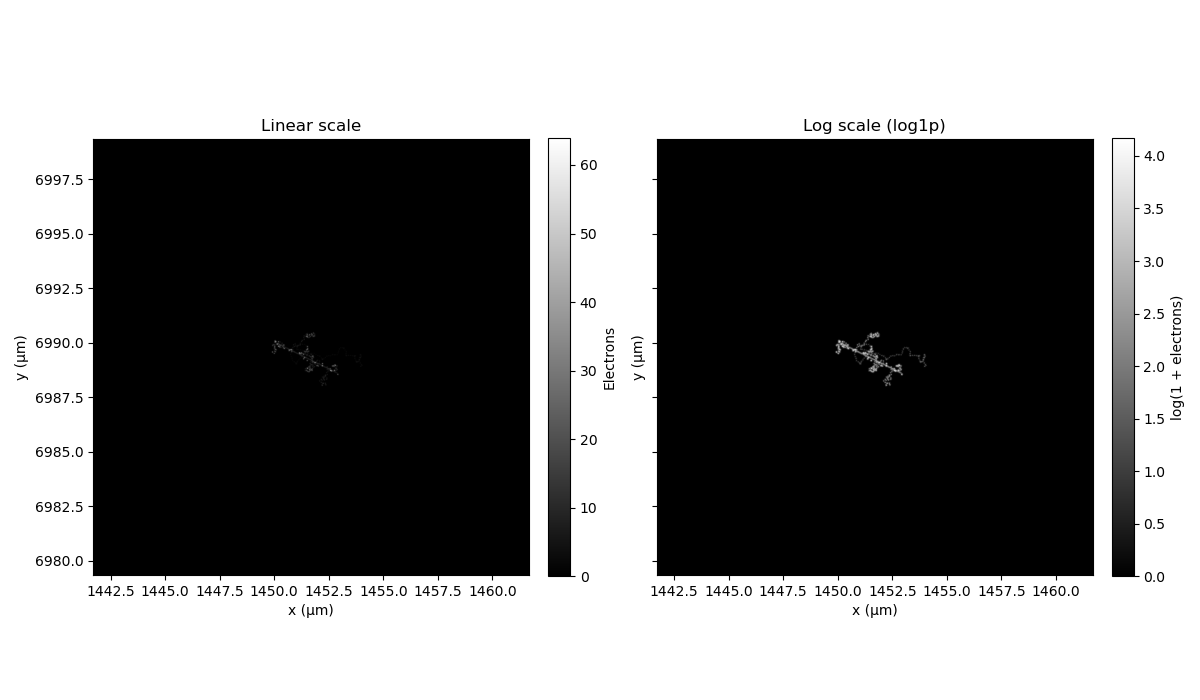

In [15]:
# ---- User Settings ----
csvfile = '202506242308_energy_loss_log.csv'
pixel_size = 10.0         # µm
grid_pixels = 2
window_size = grid_pixels * pixel_size  # 20 µm
bin_size = 0.01           # µm
nbins = int(window_size / bin_size)     # 2000
chunksize = 100_000

# --- Make the sum-of-Gaussians kernel once ---
kernel_size = 15  # You can increase for more spread if needed
kernel = gaussian_sum_kernel(size=kernel_size, sigma=0.314)

# Step 1: Find the first primary PID in the file
primary_pid = None
for chunk in pd.read_csv(csvfile, sep=',', chunksize=1):
    primary_pid = chunk['PID'].iloc[0]
    break

# Step 2: Accumulate electrons using Gaussian spreading (no giant lists)
H = np.zeros((nbins, nbins), dtype=float)
x_events, y_events = [], []

for chunk in pd.read_csv(csvfile, sep=',', chunksize=chunksize):
    pids = chunk['PID'].to_numpy()
    xs = chunk['x'].to_numpy()
    ys = chunk['y'].to_numpy()
    dEs = chunk['dE'].to_numpy()
    parent_pids = np.array([CosmicRaySimulation.get_parent_pid(pid) for pid in pids])
    mask = (parent_pids == primary_pid)
    xs_sel = xs[mask]
    ys_sel = ys[mask]
    dEs_sel = dEs[mask]

    for x, y, dE in zip(xs_sel, ys_sel, dEs_sel):
        n_electrons = electron_conversion(dE)
        if n_electrons > 0:
            x_events.append(x)
            y_events.append(y)
            # --- Place electrons on the grid using the kernel ---
            # First, convert (x, y) from microns to pixel coordinates in the window
            # We'll center the window later, but for now just keep these lists

# After collecting x_events, y_events, center the window on the mean event position
if len(x_events) == 0:
    print("No electrons found for first primary PID!")
else:
    x0 = np.mean(x_events)
    y0 = np.mean(y_events)
    x_min = x0 - (window_size / 2)
    x_max = x0 + (window_size / 2)
    y_min = y0 - (window_size / 2)
    y_max = y0 + (window_size / 2)

    for x, y, dE in zip(xs_sel, ys_sel, dEs_sel):
        n_electrons = electron_conversion(dE)
        if n_electrons > 0:
            # Map the (x, y) to window pixel indices
            x_pix = int(np.floor((x - x_min) / bin_size))
            y_pix = int(np.floor((y - y_min) / bin_size))
            # Only process if within grid
            if 0 <= x_pix < nbins and 0 <= y_pix < nbins:
                spread_electrons_to_patch(H, x_pix, y_pix, n_electrons, kernel)

    # Plot as before:
    fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)
    im0 = axs[0].imshow(
        H,
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[0].set_title('Linear scale')
    axs[0].set_xlabel('x (µm)')
    axs[0].set_ylabel('y (µm)')
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Electrons')

    im1 = axs[1].imshow(
        np.log1p(H),
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[1].set_title('Log scale (log1p)')
    axs[1].set_xlabel('x (µm)')
    axs[1].set_ylabel('y (µm)')
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label('log(1 + electrons)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [16]:

# --- Parameters ---
csvfile = '202506242308_energy_loss_log.csv'
pixel_size_hi = 0.1    # µm (simulation resolution)
pixel_size_lo = 10.0   # µm (detector pixel)
det_pixels_lo = 4096
kernel_size_hi = 50    # High-res patch size (must be odd, e.g. 50 = 5 µm square patch)
chunksize = 100_000

# --- Kernel ---
kernel = gaussian_sum_kernel(size=kernel_size_hi, sigma=0.314)

H_detector = np.zeros((det_pixels_lo, det_pixels_lo), dtype=float)

for chunk in pd.read_csv(csvfile, sep=',', chunksize=chunksize):
    xs = chunk['x'].to_numpy()
    ys = chunk['y'].to_numpy()
    dEs = chunk['dE'].to_numpy()
    for x, y, dE in tqdm(zip(xs, ys, dEs), desc="Processing events"):
        n_electrons = electron_conversion(dE)
        if n_electrons > 0:
            # High-res patch center
            x_hi = int(np.floor(x / pixel_size_hi))
            y_hi = int(np.floor(y / pixel_size_hi))
            half_patch = kernel_size_hi // 2

            # Make high-res patch and spread electrons
            patch = np.zeros((kernel_size_hi, kernel_size_hi), dtype=float)
            spread_electrons_to_patch(patch, half_patch, half_patch, n_electrons, kernel)

            # Downsample patch to detector pixel(s) by summing
            patch_sum = patch.sum()  # for 5x5 or 50x50, usually lands in one detector pixel

            # Find detector pixel (integer division)
            x_lo = int(np.floor(x / pixel_size_lo))
            y_lo = int(np.floor(y / pixel_size_lo))

            if 0 <= x_lo < det_pixels_lo and 0 <= y_lo < det_pixels_lo:
                H_detector[y_lo, x_lo] += patch_sum



Processing events: 63681it [03:18, 320.26it/s]


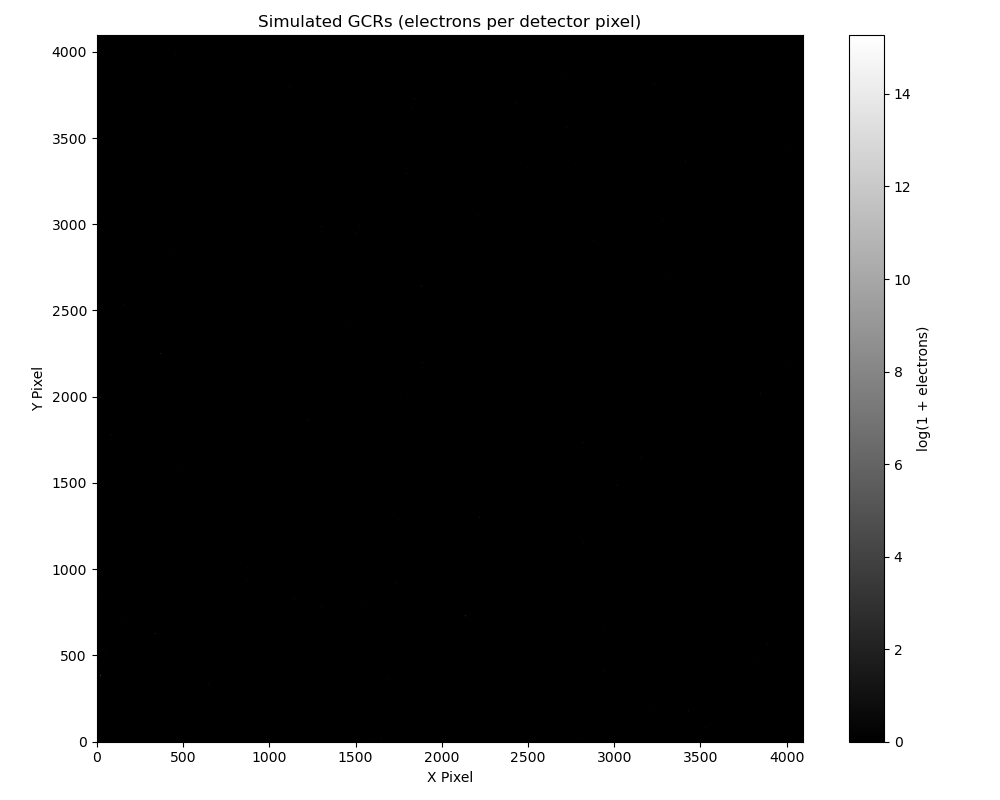

In [17]:
plt.figure(figsize=(10, 8))
plt.title("Simulated GCRs (electrons per detector pixel)")
plt.imshow(np.log1p(H_detector), cmap='gray', origin='lower')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar(label='log(1 + electrons)')
plt.tight_layout()
plt.show()


In [18]:
num_pixel_strikes = np.count_nonzero(H_detector)
print(f'Number of pixels containing simulated events = {num_pixel_strikes}')
strike_density = num_pixel_strikes/(4088**2) * (140/3.4)
print(f'This corresponds to a strike density of {strike_density:.1e} per pixel')

kruk_hirata_strike_density = 7.7e-4
print(f'In comparison, Kruk & Hirata computed an expected strike density of {kruk_hirata_strike_density:.1e}')
ratio = strike_density/kruk_hirata_strike_density
print(f'Compared to the expected strike density computed by Kruk and Hirata, ours is {(ratio-1)*100}% larger')

Number of pixels containing simulated events = 361
This corresponds to a strike density of 8.9e-04 per pixel
In comparison, Kruk & Hirata computed an expected strike density of 7.7e-04
Compared to the expected strike density computed by Kruk and Hirata, ours is 15.516446603206703% larger


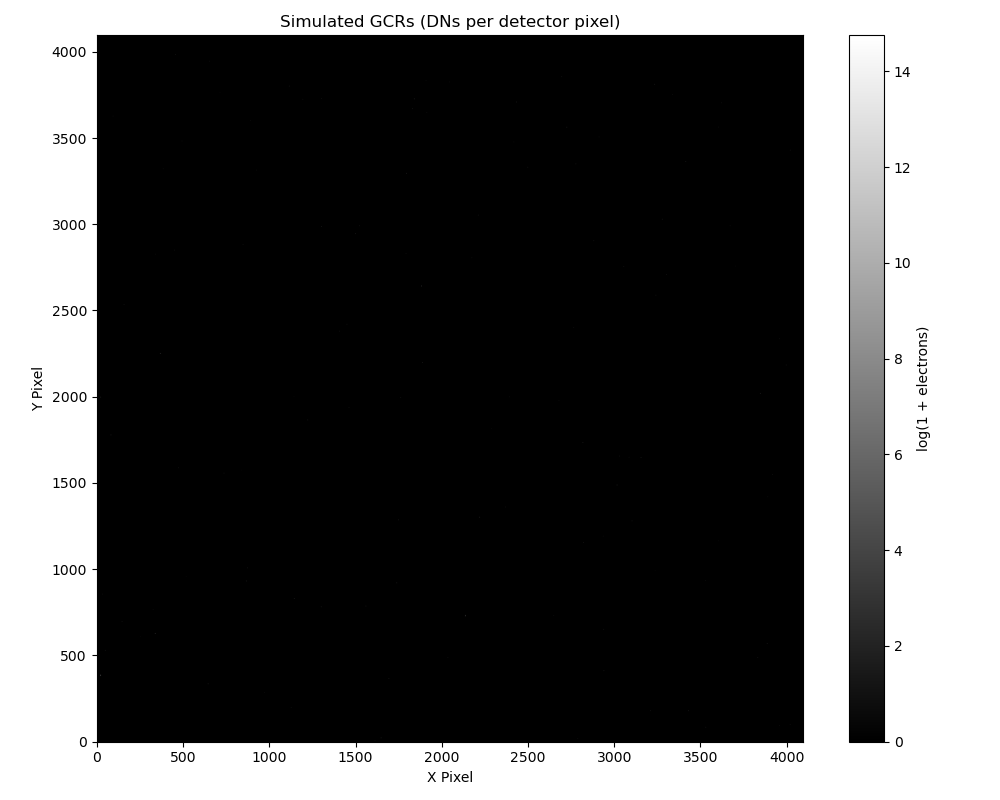

In [19]:
# Expand gain map (32x32) to full detector (4096x4096)
gain_array = np.loadtxt('Select_20663X_summary.txt')[:, 5].reshape((32, 32))
supercell_size = 128
gain_map = np.kron(gain_array, np.ones((supercell_size, supercell_size)))

assert gain_map.shape == H_detector.shape

# Convert electrons to DNs, avoiding divide by zero
gain_map_safe = np.where(gain_map > 0, gain_map, np.nan)
H_detector_DN = H_detector / gain_map_safe


plt.figure(figsize=(10, 8))
plt.title("Simulated GCRs (DNs per detector pixel)")
plt.imshow(np.log1p(H_detector_DN), cmap='gray', origin='lower')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar(label='log(1 + electrons)')
plt.tight_layout()
plt.show()


In [20]:
# Find the index (tuple) of the max value
max_idx = np.unravel_index(np.argmax(H_detector_DN), H_detector_DN.shape)
max_value = H_detector_DN[max_idx]

print(f"Largest value in H_detector_DN: {max_value:.3f} at {max_idx}")


Largest value in H_detector_DN: 2557803.548 at (932, 865)


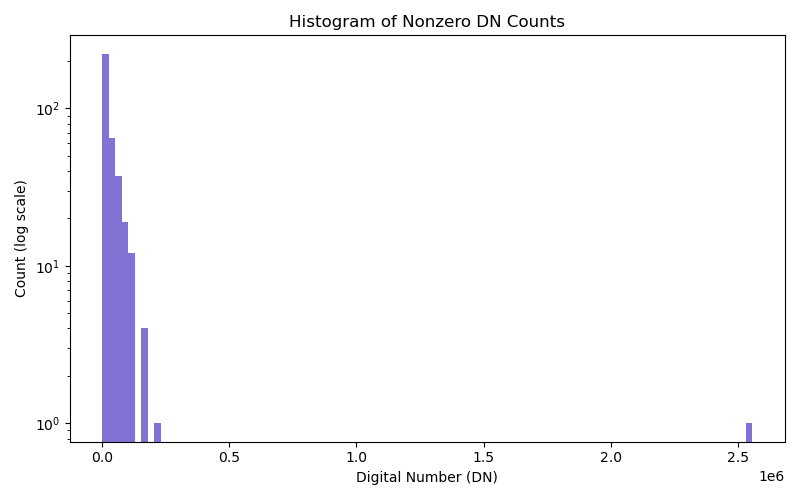

In [24]:
import matplotlib.pyplot as plt

# Flatten the array to a 1D list, mask zeros if you want only struck pixels:
dn_vals = H_detector_DN.ravel()
dn_vals_nonzero = dn_vals[dn_vals > 0]

plt.figure(figsize=(8, 5))
plt.hist(dn_vals_nonzero, bins=100, log=True, color='slateblue', alpha=0.85)
plt.xlabel('Digital Number (DN)')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Nonzero DN Counts')
plt.tight_layout()
plt.show()


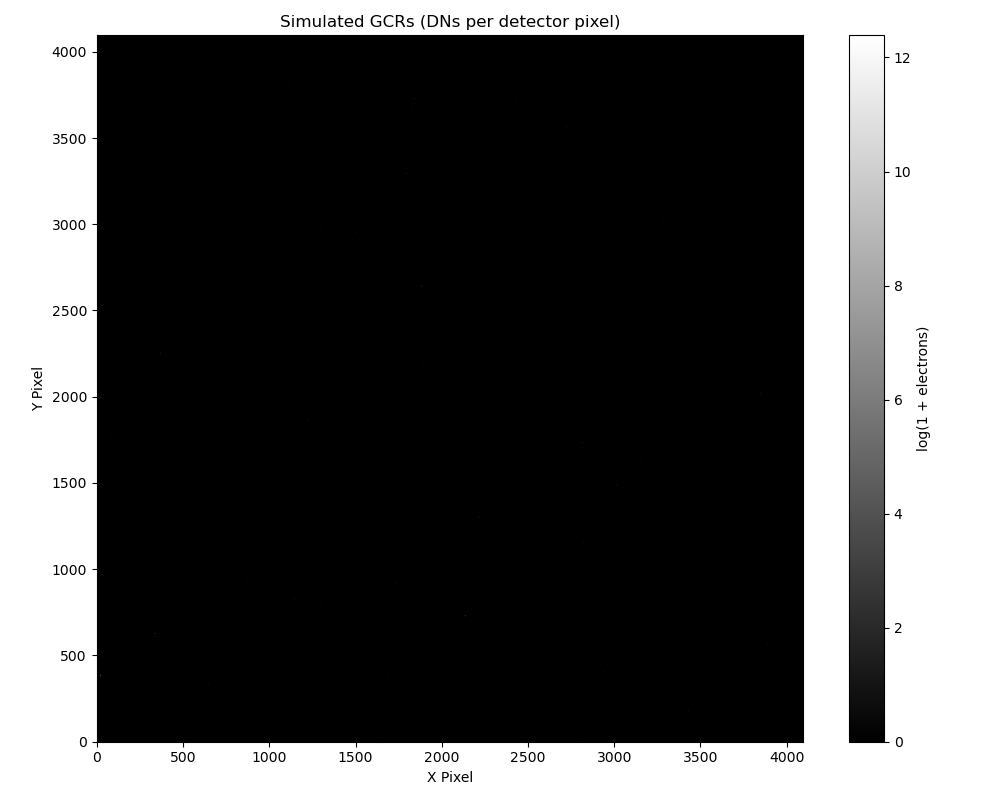

In [25]:
max_dn = 240_000
H_detector_DN_clipped = np.clip(H_detector_DN, 0, max_dn)


plt.figure(figsize=(10, 8))
plt.title("Simulated GCRs (DNs per detector pixel)")
plt.imshow(np.log1p(H_detector_DN_clipped), cmap='gray', origin='lower')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar(label='log(1 + electrons)')
plt.tight_layout()
plt.show()
